In [1]:
import itertools
import warnings
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import BLD, SRC
from src.estimation.gridsearch import (
    get_mask_around_diagonal,
    run_1d_gridsearch,
    run_2d_gridsearch,
)
from src.estimation.msm_criterion import (
    get_index_bundles,
    get_parallelizable_msm_criterion,
)
from src.manfred.shared import hash_array
from src.plotting.msm_plots import plot_estimation_moment, plot_infection_channels
from src.simulation.load_params import load_params
from src.simulation.load_simulation_inputs import load_simulation_inputs

DEBUG = False
FALL_SIM_START = pd.Timestamp("2020-09-15")
FALL_SIM_END = pd.Timestamp("2020-12-22")
SPRING_SIM_START = pd.Timestamp("2021-02-10")
SPRING_SIM_END = pd.Timestamp("2021-05-14")
if DEBUG:
    FALL_SIM_END = FALL_SIM_START + pd.Timedelta(days=5)
    SPRING_SIM_END = SPRING_SIM_START + pd.Timedelta(days=5)

warnings.filterwarnings(
    "ignore", message="indexing past lexsort depth may impact performance."
)
%load_ext snakeviz

# Load the simulation inputs

In [2]:
params = load_params("baseline")

pmsm = get_parallelizable_msm_criterion(
    prefix="gridsearch",
    fall_start_date=FALL_SIM_START,
    fall_end_date=FALL_SIM_END,
    spring_start_date=SPRING_SIM_START,
    spring_end_date=SPRING_SIM_END,
    mode="combined",
    debug=DEBUG,
)

# Modify Params

In [3]:
index_bundles = get_index_bundles(params)
hh_probs = index_bundles["hh"]
school_probs = index_bundles["school"]
young_educ_probs = index_bundles["young_educ"]
work_probs = index_bundles["work"]
other_probs = index_bundles["other"]

vacation_probs = params.query("category == 'additional_other_vacation_contact'").index
free_probs = [bundle[0] for bundle in list(index_bundles.values()) + [vacation_probs]]

In [4]:
params.loc[other_probs, "value"] = 0.15875
params.loc[young_educ_probs, "value"] = 0.005
params.loc[school_probs, "value"] = 0.01
params.loc[work_probs, "value"] = 0.1475
params.loc[hh_probs, "value"] = 0.095
params.loc[vacation_probs, "value"] = 0.5
params.loc[free_probs]

value
category                          subcategory         name                        
infection_prob                    educ_school_0       educ_school_0        0.01000
                                  educ_preschool_0    educ_preschool_0     0.00500
                                  households          households           0.09500
                                  work_non_recurrent  work_non_recurrent   0.14750
                                  other_non_recurrent other_non_recurrent  0.15875
additional_other_vacation_contact probability         Winterferien         0.50000

In [5]:
params

value
category           subcategory        name                             
infection_prob     households         households                  0.095
                   educ_school_0      educ_school_0               0.010
                   educ_school_1      educ_school_1               0.010
                   educ_school_2      educ_school_2               0.010
                   educ_preschool_0   educ_preschool_0            0.005
...                                                                 ...
rapid_test_demand  hh_member_demand   2025-12-31                  0.700
                   reaction           hh_contacts_multiplier      0.700
                                      not_hh_contacts_multiplier  0.150
seasonality_effect seasonality_effect weak                        0.150
                                      strong                      0.250

[805 rows x 1 columns]

# Run estimation

In [6]:
dimensions = "1d"

n_gridpoints = 1
loc1 = other_probs
gridspec1 = (0.15875, 0.15875, n_gridpoints)
# only used if 2d
loc2 = work_probs
gridspec2 = (0.14, 0.16, n_gridpoints)

n_seeds = 20
n_cores = 20

mask = None

In [7]:
if dimensions == "2d":
    results, grid, best_index, fig = run_2d_gridsearch(
        func=pmsm,
        params=params,
        loc1=loc1,
        gridspec1=gridspec1,
        loc2=loc2,
        gridspec2=gridspec2,
        n_seeds=n_seeds,
        n_cores=n_cores,
        mask=mask,
    )
else:
    results, grid, best_index, fig = run_1d_gridsearch(
        func=pmsm,
        params=params,
        loc=loc1,
        gridspec=gridspec1,
        n_seeds=n_seeds,
        n_cores=n_cores,
    )

In [8]:
pd.to_pickle(results, "results.pkl")

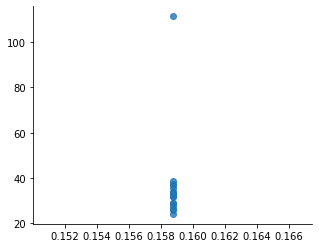

In [9]:
fig

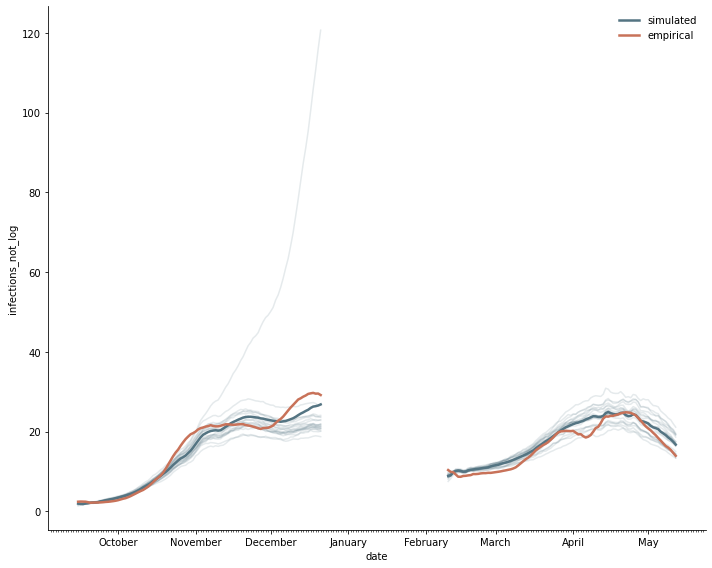

In [10]:
ix = best_index
plot_estimation_moment(results[ix], "aggregated_infections_not_log")

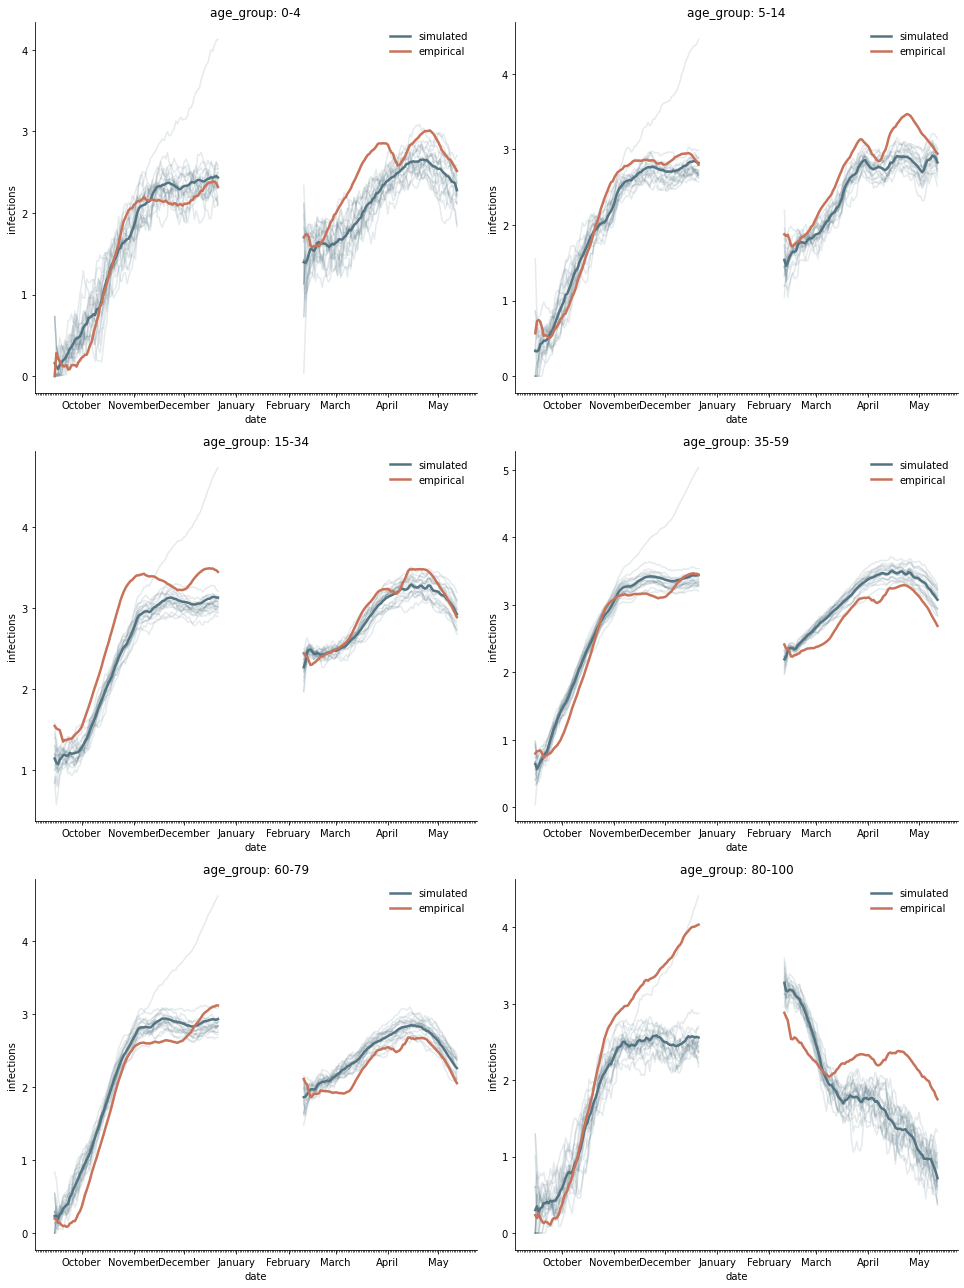

In [11]:
plot_estimation_moment(results[ix], "infections_by_age_group")

In [12]:
plot_infection_channels(results[ix], aggregate=True)

:HeatMap   [date,channel_infected_by_contact]   (share)

In [13]:
grid[best_index]

0.15875

In [14]:
best_index

0

In [15]:
np.mean([res["value"] for res in results[best_index]])
# 193

35.768051339356816

In [16]:
params.loc["rapid_test_demand"]

value
subcategory                   name                             
work                          share_accepting_offer        0.60
share_workers_receiving_offer 2020-01-01                   0.00
                              2021-01-01                   0.00
                              2021-03-17                   0.23
                              2021-04-05                   0.60
                              2021-04-15                   0.66
                              2021-06-15                   0.80
                              2025-12-13                   0.80
educ_worker_shares            2020-01-01                   0.00
                              2021-01-01                   0.00
                              2021-03-01                   0.30
                              2021-03-22                   0.90
                              2021-04-07                   0.95
                              2021-04-19                   0.95
                              2021-06-01                   0.95
                              2025-12-31                   0.95
student_shares                2020-01-01                   0.00
                              2021-02-01                   0.00
                              2021-03-01                   0.10
                              2021-03-22                   0.40
                              2021-04-07                   0.75
                              2021-04-19                   0.95
                              2021-06-01                   1.00
                              2025-12-31                   1.00
educ_frequency                before_easter                7.00
                              after_easter                 3.00
hh_member_demand              2020-01-01                   0.00
                              2021-02-01                   0.00
                              2021-03-10                   0.10
                              2021-05-15                   0.60
                              2021-05-30                   0.70
                              2025-12-31                   0.70
reaction                      hh_contacts_multiplier       0.70
                              not_hh_contacts_multiplier   0.15